# Parsing the Efficacy of Fifty-Plus Years of On-Site Metals Conservation at Sardis, Turkey

In [1]:
# this is a jupyter notebook that holds the python code used to generate visuals for a paper with the same name
# the approaches in this paper fall under the umbrella of or are inspired by network analysis 
# and aim to explore the efficacy of conservation treatment of copper alloys at sardis 
# this work was primarily conducted in spring 2019 with professors sebastian heath and roderick campbell at ISAW, NYU


In [2]:
# general imports

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

from collections import Counter


In [3]:
# access to complete dataset in excel
# creating main df: sardis_data_df

c_file = "sardismetalproject_data.xlsx"
sardis_data_df = pd.read_excel(c_file, sheet_name = "object_experiences")

# sardis_data_df # uncomment to check


In [4]:
# dataset is all of the catalogued copper alloy objects excavated from 1958-2017 on the sardis expedition, turkey 
# total number of objects in dataset

len(sardis_data_df.cat_no.unique())


852

In [5]:
# number of excavation seasons between 1958 and 2017 that at least one conservation treatment happened

len(sardis_data_df.date.unique())


55

## General Plotting

In [6]:
# i use this section of the notebook to pull out some histograms of relevant treatment instances

# these are the main variables that i have assigned by the end of this section:
# i *know* that this is way too many global variables

# cat_no_per_year_dict - a dictionary {year:all cat_nos associated with that year}
# sorted_years - a sorted dictionary {year:all cat_nos associated with that year}
# year_number_of_objects_dict - a dictionary {year:number of objects treated in that year}

# all_objects_by_year - a series of all objects treated in a year
# years - an array of years
# stable_objects - filtered df
# unstable_objects - filtered df
# stable_treatments_by_year - a series of treatment steps associated with stabillity in a year
# stable_objects_by_year - a series of stable objects in a year
# unstable_treatments_by_year - a series of treatment steps associated with instabillity in a year
# unstable_objects_by_year - a series of unstable objects in a year
# df_to_plot - plotting df
# unstable_plot
# stable_plot

# sardis_bta_df - a df with only bta treatment steps
# bta_treatments_per_year_dict - a dictionary of bta treatment steps {year:all cat_nos associated with that year}
# sorted_years_bta - a sorted dictionary of bta treatment steps {year:all cat_nos associated with that year}
# year_number_of_objects_treated_bta_dict - a dictionary of bta steps {year:number of objects treated in that year}

# stable_bta_objects - filtered df
# unstable_bta_objects - filtered df
# stable_bta_treatments_by_year - a series of bta treatment steps associated with stabillity in a year
# stable_bta_objects_by_year - a series of stable objects treated with bta in a year
# unstable_bta_treatments_by_year - a series of bta treatment steps associated with instabillity in a year
# unstable_bta_objects_by_year - a series of unstable objects treated with bta in a year
# bta_df_to_plot - bta plotting df
# unstable_bta_plot
# stable_bta_plot

# sardis_aqueous_df - a df with only aqueous treatment steps
# aqueous_treatments_per_year_dict - a dictionary of aqueous treatment steps {year:all cat_nos associated with that year}
# sorted_years_aqueous - a sorted dictionary of aqueous treatment steps {year:all cat_nos associated with that year}
# year_number_of_objects_treated_aqueous_dict - a dictionary of aqueous steps {year:number of objects treated in that year}

# stable_aqueous_objects - filtered df
# unstable_aqueous_objects - filtered df
# stable_aqueous_treatments_by_year - a series of aqueous treatment steps associated with stabillity in a year
# stable_aqueous_objects_by_year - a series of stable objects treated with water in a year
# unstable_aqueous_treatments_by_year - a series of aqueous treatment steps associated with instabillity in a year
# unstable_aqueous_objects_by_year - a series of unstable objects treated with water in a year
# aqueous_df_to_plot - aqueous plotting df
# unstable_aqueous_plot
# stable_aqueous_plot


In [7]:
# this is a cell to create a list of all the objects treated in a year

# build a 'cat_no_per_year_dict' dictionary where {key:value} = {year:all cat_nos associated with that year}

cat_no_per_year_dict = {}

for i in sardis_data_df.index:
    date = sardis_data_df['date'][i]

    if date in cat_no_per_year_dict.keys():
        if sardis_data_df['cat_no'][i] not in cat_no_per_year_dict[date]:
            cat_no_per_year_dict[date].append(sardis_data_df['cat_no'][i])   
    else:
        cat_no_per_year_dict[date] = [sardis_data_df['cat_no'][i]]

# print(len(cat_no_per_year_dict.keys())) # uncomment to check how many keys
# print(cat_no_per_year_dict) # to look at dictionary and to confirm no duplicates

# sort above, assign it to 'sorted_years' variable, print the keys and the length of the value arrays

sorted_years = dict(sorted(cat_no_per_year_dict.items()))

# make a 'year_number_of_objects_dict' dictionary where {key:value} = {year:number of objects treated in that year}
# number of objects treated = the length of the value array

year_number_of_objects_dict = {}
    
for key, value in sorted_years.items():
    year_number_of_objects_dict[key] = len(value)

# print(year_number_of_objects_dict) # uncomment to see dictionary


Text(0.5, 1.0, 'CAT Metal Objects Treated by Year')

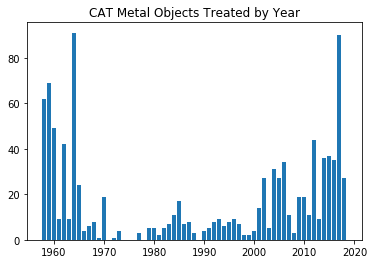

In [8]:
# histogram of objects treated in a year
# this is figure 2a

plt.bar(year_number_of_objects_dict.keys(), year_number_of_objects_dict.values())

plt.title('CAT Metal Objects Treated by Year')


Text(0.5, 1.0, 'CAT Metal Objects Treated by Year')

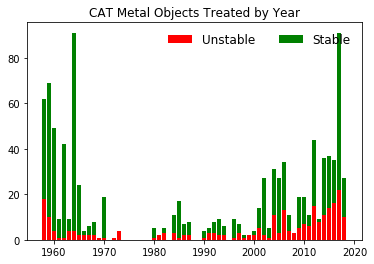

In [9]:
# histogram of objects treated in a year, split by interim stability
# this is figure 3a

# group rows by year, counting how many in each year
all_objects_by_year = sardis_data_df.groupby(sardis_data_df.date).cat_no.agg('count')

years = list(year_number_of_objects_dict.keys())

#filter dataframes to only stable / unstable rows
stable_objects = sardis_data_df.loc[sardis_data_df['interim_stability'] == 'stable']
unstable_objects = sardis_data_df.loc[sardis_data_df['interim_stability'] == 'unstable']

stable_treatments_by_year = stable_objects.groupby([stable_objects.date,stable_objects.cat_no]).cat_no.agg('count')
# ^ the result of the above is a multi-index series (indexed on 0. date, and 1. cat_no)
# then aggregating only 1 level
stable_objects_by_year = stable_treatments_by_year.groupby(level=[0]).count()

unstable_treatments_by_year = unstable_objects.groupby([unstable_objects.date,unstable_objects.cat_no]).cat_no.agg('count')
unstable_objects_by_year = unstable_treatments_by_year.groupby(level=[0]).count()

# merge into one dataframe (goal is to pad with zeros in missing years)
df_to_plot = all_objects_by_year.to_frame().merge(stable_objects_by_year.to_frame(), on="date", how="left")
df_to_plot = df_to_plot.merge(unstable_objects_by_year.to_frame(), on="date", how="left")
df_to_plot = df_to_plot.rename(index=str, columns={"cat_no_x": "total", "cat_no_y": "stable", "cat_no": "unstable"})

# plot stable bars on top of unstable bars
unstable_plot = plt.bar(years, df_to_plot['unstable'], color='r')
stable_plot = plt.bar(years, df_to_plot['stable'], bottom=df_to_plot['unstable'], color='g')

plt.legend((unstable_plot, stable_plot), ('Unstable', 'Stable'), fontsize=12, ncol=2, framealpha=0, fancybox=True)
plt.title('CAT Metal Objects Treated by Year')


In [10]:
# querying the dataset to show only bta steps

sardis_bta_df = sardis_data_df.query('treatment_step in ["bta_vac", "bta_soak", "bta_immersion", "bta_spot"]')
# sardis_bta_df # uncomment to check

# build a 'bta_treatments_per_year_dict' dictionary where {key:value} = {year:all objects that received a bta treatment that year}

bta_treatments_per_year_dict = {}

for i in sardis_bta_df.index:
    date = sardis_bta_df['date'][i]

    if date in bta_treatments_per_year_dict.keys():
        if sardis_bta_df['cat_no'][i] not in bta_treatments_per_year_dict[date]:
            bta_treatments_per_year_dict[date].append(sardis_bta_df['cat_no'][i])   
    else:
        bta_treatments_per_year_dict[date] = [sardis_bta_df['cat_no'][i]]

# print(len(bta_treatments_per_year_dict.keys())) # uncomment to check how many keys
# print(bta_treatments_per_year_dict) # uncomment to look at dictionary and confirm no duplicates

# sort above, assign it to 'sorted_years_bta' variable, print the keys and the length of the value arrays

sorted_years_bta = dict(sorted(bta_treatments_per_year_dict.items()))

# make a 'year_number_of_objects_treated_bta_dict' dictionary where {key:value} = {year:number of objects that received a bta treatment that year}
# number of objects treated = the length of the value array

year_number_of_objects_treated_bta_dict = {}
    
for key, value in sorted_years_bta.items():
    year_number_of_objects_treated_bta_dict[key] = len(value)

# print(year_number_of_objects_treated_bta_dict) # uncomment to see dictionary


(1960, 2020)

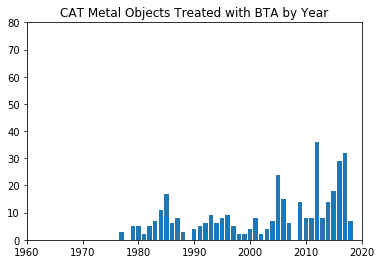

In [11]:
# histogram of any BTA conservation treatments by year
# this is figure 2b

plt.bar(year_number_of_objects_treated_bta_dict.keys(), year_number_of_objects_treated_bta_dict.values())

plt.title('CAT Metal Objects Treated with BTA by Year')
plt.ylim([0,80])  # set the ylim to 0, 80 to match figure 3a and 3c
plt.xlim([1960,2020])  # set the xlim to 1960, 2020 to match figure 3a and 3c


(1960, 2020)

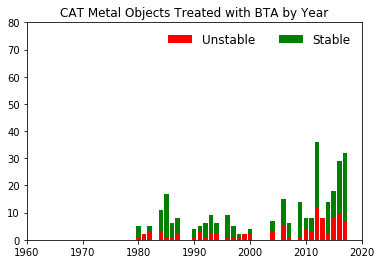

In [12]:
# histogram of any objects treated with a BTA conservation treatment by year, split by interim stability
# this is figure 3b

#filter dataframes to only stable / unstable rows
stable_bta_objects = sardis_bta_df.loc[sardis_bta_df['interim_stability'] == 'stable']
unstable_bta_objects = sardis_bta_df.loc[sardis_bta_df['interim_stability'] == 'unstable']

stable_bta_treatments_by_year = stable_bta_objects.groupby([stable_bta_objects.date, stable_bta_objects.cat_no]).cat_no.agg('count')
# ^ the result of the above is a multi-index series (indexed on 0. date, and 1. cat_no)
# then aggregating only 1 level
stable_bta_objects_by_year = stable_bta_treatments_by_year.groupby(level=[0]).count()

unstable_bta_treatments_by_year = unstable_bta_objects.groupby([unstable_bta_objects.date, unstable_bta_objects.cat_no]).cat_no.agg('count')
unstable_bta_objects_by_year = unstable_bta_treatments_by_year.groupby(level=[0]).count()

# merge into one dataframe (goal is to pad with zeros in missing years)
bta_df_to_plot = all_objects_by_year.to_frame().merge(stable_bta_objects_by_year.to_frame(), on="date", how="left")
bta_df_to_plot = bta_df_to_plot.merge(unstable_bta_objects_by_year.to_frame(), on="date", how="left")
bta_df_to_plot = bta_df_to_plot.rename(index=str, columns={"cat_no_x": "total", "cat_no_y": "stable", "cat_no": "unstable"})

# plot stable bars on top of unstable bars
unstable_bta_plot = plt.bar(years, bta_df_to_plot['unstable'], color='r')
stable_bta_plot = plt.bar(years, bta_df_to_plot['stable'], bottom=bta_df_to_plot['unstable'], color='g')

plt.legend((unstable_bta_plot, stable_bta_plot), ('Unstable', 'Stable'), fontsize=12, ncol=2, framealpha=0, fancybox=True)
plt.title('CAT Metal Objects Treated with BTA by Year')
plt.ylim([0,80])  # set the ylim to 0, 80 to match other figures
plt.xlim([1960,2020])  # set the xlim to 1960, 2020 to match other figures


In [13]:
# querying the dataset to show only aqueous steps

sardis_aqueous_df = sardis_data_df.query('treatment_step in ["aqueous_soak", "boiled", "aqueous_detergent_soak"]')
# sardis_aqueous_df # uncomment to check

# build a 'aqueous_treatments_per_year_dict' dictionary where {key:value} = {year:all objects that received an aqueous treatment that year}

aqueous_treatments_per_year_dict = {}

for i in sardis_aqueous_df.index:
    date = sardis_aqueous_df['date'][i]

    if date in aqueous_treatments_per_year_dict.keys():
        if sardis_aqueous_df['cat_no'][i] not in aqueous_treatments_per_year_dict[date]:
            aqueous_treatments_per_year_dict[date].append(sardis_aqueous_df['cat_no'][i])   
    else:
        aqueous_treatments_per_year_dict[date] = [sardis_aqueous_df['cat_no'][i]]

# print(len(aqueous_treatments_per_year_dict.keys())) # uncomment to check how many keys
# print(aqueous_treatments_per_year_dict) # uncomment to look at dictionary and confirm no duplicates

# sort above, assign it to 'sorted_years_bta' variable, print the keys and the length of the value arrays

sorted_years_aqueous = dict(sorted(aqueous_treatments_per_year_dict.items()))

# make a 'year_number_of_objects_treated_aqueous_dict' dictionary where {key:value} = {year:number of objects that received an aqueous treatment that year}
# number of objects treated = the length of the value array

year_number_of_objects_treated_aqueous_dict = {}
    
for key, value in sorted_years_aqueous.items():
    year_number_of_objects_treated_aqueous_dict[key] = len(value)

# print(year_number_of_objects_treated_aqueous_dict) # uncomment to see dictionary


Text(0.5, 1.0, 'CAT Metal Objects Treated with Water by Year')

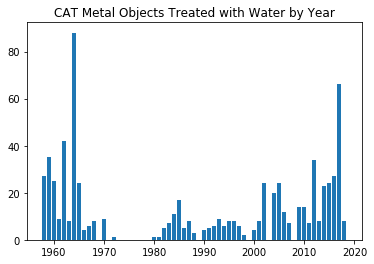

In [14]:
# histogram of any aqueous conservation treatments by year
# this is figure 2c

plt.bar(year_number_of_objects_treated_aqueous_dict.keys(), year_number_of_objects_treated_aqueous_dict.values())

plt.title('CAT Metal Objects Treated with Water by Year')


Text(0.5, 1.0, 'CAT Metal Objects Treated with Water by Year')

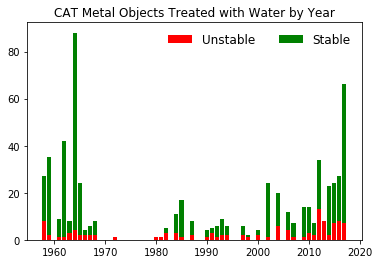

In [15]:
# histogram of any objects treated with an aqueous conservation treatment by year, split by interim stability
# this is figure 3c

#filter dataframes to only stable / unstable rows
stable_aqueous_objects = sardis_aqueous_df.loc[sardis_aqueous_df['interim_stability'] == 'stable']
unstable_aqueous_objects = sardis_aqueous_df.loc[sardis_aqueous_df['interim_stability'] == 'unstable']

stable_aqueous_treatments_by_year = stable_aqueous_objects.groupby([stable_aqueous_objects.date, stable_aqueous_objects.cat_no]).cat_no.agg('count')
# ^ the result of the above is a multi-index series (indexed on 0. date, and 1. cat_no)
# then aggregating only 1 level
stable_aqueous_objects_by_year = stable_aqueous_treatments_by_year.groupby(level=[0]).count()

unstable_aqueous_treatments_by_year = unstable_aqueous_objects.groupby([unstable_aqueous_objects.date, unstable_aqueous_objects.cat_no]).cat_no.agg('count')
unstable_aqueous_objects_by_year = unstable_aqueous_treatments_by_year.groupby(level=[0]).count()

# merge into one dataframe (goal is to pad with zeros in missing years)
aqueous_df_to_plot = all_objects_by_year.to_frame().merge(stable_aqueous_objects_by_year.to_frame(), on="date", how="left")
aqueous_df_to_plot = aqueous_df_to_plot.merge(unstable_aqueous_objects_by_year.to_frame(), on="date", how="left")
aqueous_df_to_plot = aqueous_df_to_plot.rename(index=str, columns={"cat_no_x": "total", "cat_no_y": "stable", "cat_no": "unstable"})

# plot stable bars on top of unstable bars
unstable_aqueous_plot = plt.bar(years, aqueous_df_to_plot['unstable'], color='r')
stable_aqueous_plot = plt.bar(years, aqueous_df_to_plot['stable'], bottom=aqueous_df_to_plot['unstable'], color='g')

plt.legend((unstable_aqueous_plot, stable_aqueous_plot), ('Unstable', 'Stable'), fontsize=12, ncol=2, framealpha=0, fancybox=True)
plt.title('CAT Metal Objects Treated with Water by Year')


## Building and Graphing Path Networks 

In [16]:
# i used this section of the notebook to make figure 1

# these are the main variables that i have assigned by the end of this section:

# sardis_data_sorted_df - a df sorted by excavation year
# edge_colors - an array of edge colors based on int_s of target node
# unique_treatments_df - a df of unique treatments and their RBG values to control node color
# unique_treatments_dict - a dictionary {ts attribute of node: r,g,b values}
# node_colors - an array of edge colors from the unique_treatments_df
# labels - a dictionary {sardismetalproject_id: cat_no}


In [17]:
# new sorted-by-date df sorted in chronological order

sardis_data_sorted_df = pd.read_excel(c_file, sheet_name = "object_experiences_sorted")

# sardis_data_sorted_df # uncomment to check


In [18]:
# loop through cat_no column, create directed path network for each unique value (i.e. object),
# and list the next_treatment column values

P = nx.DiGraph()

for obj in sardis_data_sorted_df.cat_no.unique(): 
    temp_df = sardis_data_sorted_df.query('cat_no == "{}"'.format(obj))
    for r in temp_df.iterrows():
        # assigning attributes to nodes and edges
        P.add_node(r[1]['sardismetalproject_id'], cn = r[1]['cat_no'], ts = r[1]['treatment_step'], d = r[1]['date'], int_s = r[1]['interim_stability'])
        P.add_node(r[1]['next_treatment'], cn = r[1]['cat_no'], ts = r[1]['treatment_step'], d = r[1]['date'], int_s = r[1]['interim_stability'])
        P.add_edge(r[1]['sardismetalproject_id'], r[1]['next_treatment'], ts = r[1]['treatment_step'], d = r[1]['date'], int_s = r[1]['interim_stability'])   

# P.edges # uncomment to check edges
# P.nodes # uncomment to check nodes


In [19]:
# take control of P layout
# create 'path' dictionary where {key:value} = {sardismetalproject_id:coordinates}

x_step = 100
offset = 600

path = {'stable':[-(offset/100),0]}

# P.predecessors('stable')

c_x = -offset
c_y = 10000 # change to move stable node location

for c_p in P.predecessors('stable'):
    
    has_neighbor = True
    
    path[c_p] = [c_x, c_y]
    
    while has_neighbor:
        path[c_p] = [c_x, c_y]
        try:
            c_p = [step for step in P.predecessors(c_p)][0]
        except:
            # if the try statement fails, execute this code
            has_neighbor = False
            c_x = -offset
            c_y = c_y - 100
        else:
            # otherwise keep on running
            c_x = c_x - x_step
        
path['unstable'] = [offset/100,0]

# P.predecessors('unstable')

c_x = offset
c_y = 10000 # change to move unstable node location

for n in P.predecessors('unstable'):
    
    has_neighbor = True
    
    path[n] = [c_x, c_y]
    c_p = n
    
    while has_neighbor:
        path[c_p] = [c_x, c_y]
        try:
            c_p = [step for step in P.predecessors(c_p)][0]
        except:
            has_neighbor = False
            c_x = offset
            c_y = c_y - 100
        else:
            c_x = c_x + x_step
            
# path # uncomment to check 


In [20]:
# look at the int_s attribute of the nodes; if target node is unstable make red; if target node is stable make green

edge_colors = []

for e in P.edges:
    if P.nodes[e[1]]['int_s'] == 'unstable':
        edge_colors.append((0.5,0,0))
    if P.nodes[e[1]]['int_s'] == 'stable':
        edge_colors.append((0,0.5,0))
        
# edge_colors # uncomment to check     


In [21]:
# create new unique_treatments_df to control node colors

unique_treatments_df = pd.read_excel(c_file, sheet_name = "unique_treatments")

# unique_treatments_df # uncomment to check

# transpose unique_treatments_df into 'unique_treatments_dict' dictionary where 
# {key:value} = {ts attribute of node: r,g,b values}

unique_treatments_dict = unique_treatments_df.set_index('treatment_step').transpose().to_dict()

# unique_treatments_dict # uncomment to check


In [22]:
# color nodes according to r, g, b values in unique_treatments_dict

node_colors = []

for no in P.nodes:
    match = unique_treatments_dict[P.nodes[no]['ts']]
    node_colors.append((match['r'], match['g'], match['b']))
    
# len(node_colors) # uncomment to check


In [23]:
# draw and label
# this cell is used to generate figure 1

figure(figsize = (80, 100), dpi = 100)

nx.draw(P, path, node_size = 100,
        node_color = node_colors,
        alpha = 0.8, width = 5,
        edge_color = edge_colors,
        arrowsize = 1)

# sardismetalproject_id labels
# n = nx.draw_networkx_labels(P, path, font_size = 10)

# if it has_neighbor then don't print label; bool func returns true or false re: neighbor
def has_neighbor(node_id):
    return bool(len(list(P.predecessors(node_id))))

# move each label over by label_offset pixels
label_offset = 0
new_path = {}
for smp_id, coords in path.items():
    if smp_id in P.predecessors('stable'):
        label_offset = -100
    elif smp_id in P.predecessors('unstable'):
        label_offset = 100
    new_path[smp_id] = [coords[0] + label_offset, coords[1]]

# create dictionary {smp_id:label (from cn attribute)} built up from the 'path' dictionary
# only include a node in the label dictionary if it has no neighbors (i.e. there should be one label per object)
labels = {smp_id:P.nodes[smp_id]['cn'] for smp_id in list(path.keys())[1:] if not has_neighbor(smp_id)}
n = nx.draw_networkx_labels(P, new_path, labels, font_size = 12, alpha = 0.8)

# for facility in zooming in
plt.savefig("figure1.pdf")


## Comparing Path Similarity

In [24]:
# these are the main variables that i have assigned by the end of this section:

# stable_step_sequence_dict - a dictionary {cat_no: list of next_treatment values ending in stable}
# unstable_step_sequence_dict - a dictionary {cat_no: list of next_treatment values ending in unstable}
# were_all_steps_performed - a function (cat_no, steps_of_interest, step_sequence_dict)
# steps_of_interest_to_test - an array of arrays i am interested in looking at
# stable_cnt - a counter for the stable steps_of_interest_to_test array 
# unstable_cnt - a counter for the unstable steps_of_interest_to_test array 
# contains_substring - an array of arrays i am interested in looking at
# stable_substring_cnt - a counter for the stable contains_substring array 
# unstable_substring_cnt - a counter for the unstable contains_substring array 


In [25]:
# build up each individual path into 'stable_step_sequence_dict' dictionary of lists

stable_step_sequence_dict = {}

# iterate over all paths that end in 'stable'
# build up the steps in reverse (starting with stable and going backwards)
for smp_id in P.predecessors('stable'):
    # get the cat_no associated with this treatment_step
    cat_no = P.nodes[smp_id]['cn'] 

    has_predecessor = True

    # set the first 2 steps as 'stable', followed by the ultimate treatment step
    stable_step_sequence_dict[cat_no] = ['stable', smp_id]

    while has_predecessor:
        try:
            predecessor = list(P.predecessors(smp_id))[0] # capture the preceding treatment step
            stable_step_sequence_dict[cat_no].append(predecessor) # add it to the list of steps
            smp_id = predecessor # move on to the next loop iteration
        except:
            # if the above code throws an exception, continue with next object (end the while loop)
            has_predecessor = False

# repeat for sequences ending in unstable, creating 'unstable_step_sequence_dict'

unstable_step_sequence_dict = {}

for smp_id in P.predecessors('unstable'):
    cat_no = P.nodes[smp_id]['cn'] 
    has_predecessor = True

    unstable_step_sequence_dict[cat_no] = ['unstable', smp_id]

    while has_predecessor:
        try:
            predecessor = list(P.predecessors(smp_id))[0]
            unstable_step_sequence_dict[cat_no].append(predecessor)
            smp_id = predecessor
        except:
            has_predecessor = False

# reverse list so in chronological order
for cat_no, steps in stable_step_sequence_dict.items():
    steps = steps.reverse()

num_stable_objects = len(list(stable_step_sequence_dict.keys()))
print(f'{num_stable_objects} objects end in stable')

for cat_no, steps in unstable_step_sequence_dict.items():
    steps = steps.reverse()

num_unstable_objects = len(list(unstable_step_sequence_dict.keys()))
print(f'{num_unstable_objects} objects end in unstable')


768 objects end in stable
84 objects end in unstable


In [26]:
# in this cell i am looking at sequences of interest
# specifically, i am looking at "set inclusion" of particular treatment steps in an object's treatment history
# note: order doesn't matter
# note: other steps in between the steps of interest don't matter
# note: step repeats don't matter
# the information generated by this cell is used in fig. 5

# how many objects have these steps and end in stability? # how many objects have these steps and end in instability?

def were_all_steps_performed(cat_no, steps_of_interest, step_sequence_dict):
        smp_ids = step_sequence_dict[cat_no]
        treatment_steps = set([P.nodes[smp_id]['ts'] for smp_id in smp_ids])
        was_step_performed = [step in treatment_steps for step in steps_of_interest]
        return all(was_step_performed)

stable_cnt, unstable_cnt  = Counter(), Counter()

# steps_of_interest_to_test can be changed to include any steps or combination of steps in the unique_treatments_df
steps_of_interest_to_test = [
    ['bta_vac'],
    ['bta_soak'],
    ['bta_immersion'],
    ['bta_spot'],
    ['aqueous_soak'],
    ['boiled'],
    ['aqueous_detergent_soak'],
    ['bta_vac', 'aqueous_soak'],
    ['bta_soak', 'aqueous_soak'],
    ['bta_immersion', 'aqueous_soak'],
    ['bta_spot', 'aqueous_soak'],
    ['bta_vac', 'boiled'],
    ['bta_soak', 'boiled'],
    ['bta_immersion', 'boiled'],
    ['bta_spot', 'boiled'],
    ['bta_vac', 'aqueous_detergent_soak'],
    ['bta_soak', 'aqueous_detergent_soak'],
    ['bta_immersion', 'aqueous_detergent_soak'],
    ['bta_spot', 'aqueous_detergent_soak']
]

for steps_to_test in steps_of_interest_to_test:
    for cat_no, _ in stable_step_sequence_dict.items():
        if were_all_steps_performed(cat_no, steps_to_test, stable_step_sequence_dict):
            stable_cnt['_and_'.join(steps_to_test)] += 1

    for cat_no, _ in unstable_step_sequence_dict.items():
        if were_all_steps_performed(cat_no, steps_to_test, unstable_step_sequence_dict):
            unstable_cnt['_and_'.join(steps_to_test)] += 1

print('For objects ending in stable, here is how many contained these treatment steps (set inclusion)')
print (dict(stable_cnt))

print() # space

print('For objects ending in unstable, here is how many contained these treatment steps (set inclusion)')
print (dict(unstable_cnt))


For objects ending in stable, here is how many contained these treatment steps (set inclusion)
{'bta_vac': 209, 'bta_immersion': 83, 'aqueous_soak': 480, 'boiled': 10, 'aqueous_detergent_soak': 158, 'bta_vac_and_aqueous_soak': 202, 'bta_immersion_and_aqueous_soak': 65, 'bta_vac_and_boiled': 1, 'bta_immersion_and_boiled': 10, 'bta_vac_and_aqueous_detergent_soak': 1}

For objects ending in unstable, here is how many contained these treatment steps (set inclusion)
{'bta_vac': 49, 'bta_soak': 2, 'bta_immersion': 9, 'bta_spot': 1, 'aqueous_soak': 62, 'boiled': 2, 'aqueous_detergent_soak': 4, 'bta_vac_and_aqueous_soak': 47, 'bta_soak_and_aqueous_soak': 2, 'bta_immersion_and_aqueous_soak': 8, 'bta_spot_and_aqueous_soak': 1, 'bta_vac_and_boiled': 2, 'bta_immersion_and_boiled': 2}


In [27]:
# in this cell i am looking at sequences of interest
# specifically, i am looking at "substring comaprison" within an object's treatment history
# note: order/consequetive-ness does matter
# the information generated by this cell is used in fig. 6

def contains_substring(cat_no, steps_of_interest, step_sequence_dict):
        smp_ids = step_sequence_dict[cat_no]
        treatment_steps = '_'.join([P.nodes[smp_id]['ts'] for smp_id in smp_ids])
        steps_of_interest_string = '_'.join(steps_of_interest)
        return steps_of_interest_string in treatment_steps

stable_substring_cnt, unstable_substring_cnt  = Counter(), Counter()

# steps_of_interest_to_test can be changed to include any steps or combination of steps in the unique_treatments_df
steps_of_interest_to_test = [
    ['aqueous_soak', 'mechanical_clean', 'bta_vac'],
    ['aqueous_soak', 'mechanical_clean', 'bta_immersion'],
    ['aqueous_soak', 'mechanical_clean', 'bta_soak'],
    ['aqueous_soak', 'mechanical_clean', 'bta_spot'],
    ['boiled', 'bta_vac'],
    ['boiled', 'bta_immersion'],
    ['boiled', 'bta_soak'],
    ['boiled', 'bta_spot'],
    ['aqueous_detergent_soak', 'bta_vac'],
    ['aqueous_detergent_soak', 'bta_immersion'],
    ['aqueous_detergent_soak', 'bta_soak'],
    ['aqueous_detergent_soak', 'bta_spot']
]

for steps_to_test in steps_of_interest_to_test:
    for cat_no, _ in stable_step_sequence_dict.items():
        if contains_substring(cat_no, steps_to_test, stable_step_sequence_dict):
            stable_substring_cnt['_then_'.join(steps_to_test)] += 1

    for cat_no, _ in unstable_step_sequence_dict.items():
        if contains_substring(cat_no, steps_to_test, unstable_step_sequence_dict):
            unstable_substring_cnt['_then_'.join(steps_to_test)] += 1

print('For objects ending in stable, here is how many contained these treatment steps (substring)')
print (dict(stable_substring_cnt))

print() # space

print('For objects ending in unstable, here is how many contained these treatment steps (substring)')
print (dict(unstable_substring_cnt))


For objects ending in stable, here is how many contained these treatment steps (substring)
{'aqueous_soak_then_mechanical_clean_then_bta_vac': 177, 'aqueous_soak_then_mechanical_clean_then_bta_immersion': 44, 'boiled_then_bta_immersion': 10}

For objects ending in unstable, here is how many contained these treatment steps (substring)
{'aqueous_soak_then_mechanical_clean_then_bta_vac': 38, 'aqueous_soak_then_mechanical_clean_then_bta_immersion': 2, 'boiled_then_bta_immersion': 2}


In [ ]:
# this cell begins to plot the above set inclusion results as histogram
# at this point, i found this data to be more useful as a way to color figure 1, and never finished tweaking this graph

fig, ax = plt.subplots()
bar_width= 0.3
x_space_between_series = 0.3

# make list for x axis by unioning sets
combined_set_of_treatments = list(set(dict(stable_cnt).keys()).union(set(dict(unstable_cnt).keys())))

# make new y values for stable
stable_y_values = [None] * len(combined_set_of_treatments)
unstable_y_values = [None] * len(combined_set_of_treatments)
for index,treatment_steps in enumerate(combined_set_of_treatments):
    stable_y_values[index] = stable_cnt[treatment_steps]
    unstable_y_values[index] = unstable_cnt[treatment_steps]

x_values = list(range(len(combined_set_of_treatments)))
x_values2 = [x+x_space_between_series for x in x_values]
 
b1 = ax.bar(x_values, stable_y_values, color='g', width=bar_width)
b2 = ax.bar(x_values2, unstable_y_values, color='r', width=bar_width)

ax.set_title('Combinations of BTA/Aqueous Treatment Steps')
ax.set_xticklabels(combined_set_of_treatments)
plt.xticks(rotation=90)
ax.legend(['Currently stable', 'Currently unstable'])
ax.autoscale_view()
plt.show()
